# Patch Generator
### On this notebook, we will generate the patches to be used for training.

### We can choose the patch zise, the stride to generate patches, which type of images will be used for validation, the minimum amount of positive pixels for a patch to be considered as positive, and some other features of the patches to be generated (see full explanation further below).

### Data was already downloaded into the Git Repository, in the folder '../Data', which contains the following subfolders:
    1. Serial: Folder containing all 'Serial' type images.
    2. Control: Folder containing all 'Control' type images.
    3. Streak: Folder containing all 'Streak' type images.

### In addition, <span style="color:blue">*prepocessed images*</span>  can already be found in <span style="color:blue">'../Data/no_dish_border/'</span> folder also containing the following subfolders:
    1. Serial: Folder containing all pre-processed 'Serial' type images.
    2. Control: Folder containing all pre-processed 'Control' type images.
    3. Streak: Folder containing all pre-processed 'Streak' type images.
    
### Positive pixel <span style="color:blue">*Masks*</span> were already obtained and can be found in <span style="color:blue">'../Data/Masks'</span> folder also containing the following subfolders:
    1. Serial: Folder containing all positive masks for 'Serial' type images.
    2. Control: Folder containing all positive masks for 'Control' type images.
    3. Streak: Folder containing all positive masks for 'Streak' type images.
    
### Using the positive pixel masks, <span style="color:blue">*positive-pixels-only images*</span> were generated and can be found in <span style="color:blue">'../Data/pos_pixel_only/'</span> folder also containing the following subfolders:
    1. Serial: Folder containing all positive-pixels-only images for 'Serial' type images.
    2. Control: Folder containing all positive-pixels-only images for 'Control' type images.
    3. Streak: Folder containing all positive-pixels-only images for 'Streak' type images.

### Let's import necessary libraries / modules:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from PIL import Image, ImageOps
import cv2 as cv

%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Helper Function: get a list of 'complete' file paths of all images in a given folder:

In [3]:
def get_files(folder):
    """
    Returns a list of file_paths for each file in the specified folder. 
    :param folder: The folder where files are located.
    :return: A list of file_paths for each file in the specified folder.
    """
    files = os.listdir(folder)
    paths = []
    for x in files:
        paths.append(os.path.join(folder, x))
    return paths

### Helper Function: 
#### Create all needed folders and subfolders.

In [4]:
def create_folders(patch_size):
    """
    Create all needed folders to save the created Patches.
    :param patch_size: Tuple. (Patch_width, Patch_height) e.g. (64 ,64).
    :return: save_dir. The root directory where Patches will be saved.
    """ 
    folder_name = 'Patches_' + str(patch_size[0]) + 'x' + str(patch_size[1])
    save_dir = '../Data/' + folder_name + '/'
    
    if folder_name in os.listdir('../Data'):
        shutil.rmtree(save_dir)
    os.mkdir(save_dir)
    
    for folder in ['Positive', 'Negative']:
        path = save_dir + '/' + folder
        os.mkdir(path)
        for type_ in ['Serial', 'Control', 'Streak']:
            type_path = path + '/' + type_
            os.mkdir(type_path)
            for i in range(1,11):
                loc = 'C{}_{}'.format(i, folder.lower()[:3])
                loc_path = type_path + '/' + loc
                os.mkdir(loc_path)
    return save_dir

## Patch Generator function

In [5]:
def create_patches(img_types, patch_types, patch_size, stride, min_pos_pixels, val_type,
                   val_stride, val_min_pos_pixels, include_dish_border=False,
                   positive_pixels_only=False, rotations=False, val_rotations=False,
                   flips=['None'], val_flips=['None']):
    """
    Creates patches for training.
    :param img_types: List. List of images types patching. Any combination from ['Serial',
                         'Control', 'Stride'] -one, two or all three-.
    :param patch_types: List. List with types of patches to generate for each location.
                        Either ['Positive'] or ['Negative'] or ['Positive','Negative'].
    :param patch_size: Tuple. (patch_width, patch_height) e.g. (64 ,64).
    :param stride: Tuple. (horizontal_stride, vertical_stride).
                   Amount of pixels to move right or down  to generate next patch.
    :param min_pos_pixels: Integer. Minimum positive pixels in patches.
                           Values from 1 pixel to patch_width*patch_height (all pixels).
    :param val_type: Str. Type of images to be used for model validation.
                                 either 'Control', 'Serial', 'Strike' or None.
    :param val_stride: Tuple. (horizontal_stride, vertical_stride) for validation patches.
                   Amount of pixels to move right or down  to generate next validation patch.
    :param val_min_pos_pixels: Integer. Minimum positive pixels in validation patches.
                           Values from 1 pixel to patch_width*patch_height (all pixels).
    :param include_dish_border: Boolean. True ->  include petri-dish border in training patches.
    :param positive_pixels_only: Boolean. True -> patches with positive pixels only.
                                 False -> natural images including dish background (default).
    :param rotations: List of Int [0-360] or False. List with the amount of degrees to rotate the
                      training images around its center (before patching), for data augmentation. 
                      If rotations = False, then no rotation will be performed on training images.
    :param val_rotations: ListofInt [0-360] or False. Same concept than 'rotations' (see above)
                             but in this case it will be the list of degrees to rotate 'Validation'
                             images around its center. If False -> no rotation on validation.
    :param flips: List with any combination from ['None', 'hoz', 'vert', 'both'].
                  Patches will be generated from every flip setup included within the list.
                  If flips = ['None'], no flips will be performed on training images (default).
    :param val_flips: List with any combination from ['None', 'hoz', 'vert', 'both'].
                      Patches will be generated from every flip setup included within the list.
                      If val_flips = ['None'], no flips will be performed on training images (default).                     
    :return: save_dir. The root directory where Patches were saved.
    """ 
    if positive_pixels_only and include_dish_border:
        print("No border will be included when 'positive_pixels_only=TRUE'")
        
    save_dir = create_folders(patch_size)
    width, height = patch_size
    max_pixels = width * height * 255 # maximum pixel sum if all pixels in patch were white (255)
    root = '../Data/no_dish_border/'
    if include_dish_border: root = '../Data/'
    if positive_pixels_only: root = '../Data/pos_pixel_only/'
    
    for type_ in img_types:            
        print('\ngenerating "{}" patches...............'.format(type_)) 
        img_folder = root + type_
        if type_ == val_type: img_folder = '../Data/' + type_ # natural images for validation
        images = get_files(img_folder) # Returns array of all file_paths in the specified folder.
        move, min_pos = stride, min_pos_pixels
        if type_ == val_type: move, min_pos = val_stride, val_min_pos_pixels
        
        if rotations and type(rotations) is list and type_ != val_type:
            degrees = [int(rot) for rot in rotations]
        elif val_rotations and type(val_rotations) is list and type_==val_type:
            degrees = [int(val_rot) for val_rot in val_rotations]
        else:
            degrees = [0]
        
        """Setup the flip operations to be performed"""
        if flips and type(flips) is list and type_ != val_type:
            flip_list = [flip for flip in flips if flip in ['None', 'hoz', 'vert', 'both']]
        elif val_flips and type(val_flips) is list and type_==val_type:
            flip_list = [flip for flip in val_flips if flip in ['None', 'hoz', 'vert', 'both']]
        else:
            flip_list = ['None']   
        flip_operations = []
        for flip in flip_list:
            if flip == 'hoz':
                operations = {'hoz_flip': [ImageOps.mirror]}
            if flip == 'vert' or flip == 'both':
                operations = {'vert_flip': [ImageOps.flip]}
            if flip == 'both':
                operations = {'hoz+vert_flip': [ImageOps.mirror,ImageOps.flip]}
            if flip == 'None':
                operations = {'no_flip': [None]}
            flip_operations.append(operations)
            
        for img_path in images:
            if 'no_blue_numbers' in img_path: continue       # this is a folder, not an image
            original_img = Image.open(img_path)
            imgwidth, imgheight = original_img.size 
            for i in range(1,11):
                if 'C{}_'.format(i) in img_path:
                    loc = '/C{}_'.format(i)            #captures the location
            mask_path = '../Data/Masks/' + type_ + img_path[len(img_folder):]
            original_mask = Image.open(mask_path)            #positive pixels mask
            circle_mask_path = '../Data/Masks/Circles/' + type_ + img_path[len(img_folder):]
            orig_circle_mask = Image.open(circle_mask_path)  #no border petri-dish circle mask
            
            """Negatvie patches will always be taken from natural images (incl. dish border)"""
            original_neg_img, neg_img = False, False
            if 'Negative' in patch_types and not include_dish_border and type_ != val_type:
                neg_path = '../Data/' + type_ + img_path[len(img_folder):]
                original_neg_img = Image.open(neg_path)
            
            """We need to discard contaminated negative patches inside circles for C2, C9, C10:"""
            original_neg_mask, neg_mask = False, False                
            if 'C9_' in img_path or 'C2_' in img_path or 'C10_' in img_path:
                if type_ == 'Serial' and 'Negative' in patch_types and not positive_pixels_only:
                    neg_mask_path = '../Data/Masks/non-negative/Serial' + img_path[len(img_folder):]
                    original_neg_mask = Image.open(neg_mask_path)   
            
            """Also need to discard contaminated negative patches outside circles for C4,C5,C7,C8,C10:"""
            contaminated = False
            if 'C10_' in loc:
                if not '7-9_AM' in img_path: contaminated = True # 7-9_AM is not contaminated
            if 'C4_' in loc or 'C5_' in loc or 'C7_' in loc:
                if not '7-9' in img_path: contaminated = True    # 7-9 patches are not contaminated
            if 'C8_' in loc:
                if '7-11_PM' in img_path or '7-12_AM' in img_path or '7-12_PM' in img_path: 
                    contaminated = True                          # all other timestamps are not contaminated    

            for angle in degrees:
                rot_img = original_img.rotate(angle, fillcolor='white')
                rot_img = ImageOps.expand(rot_img, border=(width,height,width,height), fill='white') #expand for patching
                rot_mask = original_mask.rotate(angle, fillcolor='black')
                rot_mask = ImageOps.expand(rot_mask, border=(width,height,width,height), fill='black')
                rot_circle_mask = orig_circle_mask.rotate(angle, fillcolor='black')
                rot_circle_mask = ImageOps.expand(rot_circle_mask, border=(width,height,width,height), fill='black')
                if original_neg_img:  # means we need it to create negative patch incl. dish border
                    rot_neg_img = original_neg_img.rotate(angle, fillcolor='white')
                    rot_neg_img = ImageOps.expand(rot_neg_img, border=(width,height,width,height), fill='white')
                if original_neg_mask: # means this is a contaminated petri-dish 
                    rot_neg_mask = original_neg_mask.rotate(angle, fillcolor='black')
                    rot_neg_mask = ImageOps.expand(rot_neg_mask,border=(width,height,width,height),fill='black')
            
                for ops_dict in flip_operations: #nested list of flip operations to be performed
                    for name, ops in ops_dict.items(): #list of flip operations in be performed ('both'='hoz'+'vert')
                        flip = name
                        img = rot_img
                        mask = rot_mask
                        circle_mask = rot_circle_mask
                        if neg_img:     # means we need it to create negative patch incl. dish border
                            neg_img = rot_neg_img
                        if neg_mask:    # means this is a contaminated petri-dish
                            neg_mask = rot_neg_mask
                        for op in ops:
                            if op:
                                img = op(img)
                                mask = op(mask)
                                circle_mask = op(circle_mask)
                                if neg_img:     # means we need it to create negative patch incl. dish border
                                    neg_img = op(neg_img)
                                if neg_mask:    # means this is a contaminated petri-dish
                                    neg_mask = op(neg_mask)

                    for i in range(0,imgheight+height,move[1]):
                        for j in range(0,imgwidth+width,move[0]):
                            box = (j, i, j+width, i+height)
                            mask_patch = mask.crop(box)
                            mask_pixels = np.sum(mask_patch.convert('L'))
                            n_mask_pixels = int(mask_pixels/255.0)
                            circle_mask_patch = circle_mask.crop(box)
                            circle_mask_pixels = np.sum(circle_mask_patch.convert('L'))
                            patch = img.crop(box)
                            patch_grey = patch.convert('L')
                            pixels = np.sum(patch_grey)
                            if neg_img: # means we need it to create negative patch incl. dish border
                                neg_patch = neg_img.crop(box)
                                neg_patch_grey = neg_patch.convert('L')
                                neg_pixels = np.sum(neg_patch_grey) 
                            if neg_mask: # this is a contaminated pretri-dish
                                neg_mask_patch = neg_mask.crop(box)
                                neg_mask_pixels = np.sum(neg_mask_patch.convert('L'))

                            if 'Positive' in patch_types and n_mask_pixels >= min_pos: # This is a positive patch
                                pos_save_path = save_dir+'Positive/'+type_+loc+'pos'+img_path[:-4][len(img_folder):] \
                                    + '_' + '{}_{}_rot_{}_{}.jpg'.format(int(i/move[1]),int(j/move[0]),angle,flip)
                                patch.save(pos_save_path)

                            if 'Negative' in patch_types and mask_pixels==0:
                                if neg_mask:                         # dish may me contaminated
                                    if neg_mask_pixels > 0: continue # contaminated dish patch, do not save
                                if circle_mask_pixels < max_pixels:  # some or all pixels outside dish
                                    if contaminated: continue        # contamination outside circle, do not save
                                    if neg_img: # means we need it to create negative patch incl. dish border
                                        if neg_pixels>=0.8*max_pixels: continue # most white background
                                    else:
                                        if pixels>=0.8*max_pixels: continue # most white background
                                neg_save_path = save_dir+'Negative/'+type_+loc+'neg'+img_path[:-4][len(img_folder):] \
                                        + '_' + '{}_{}_rot_{}_{}.jpg'.format(int(i/move[1]),int(j/move[0]),angle,flip)
                                if neg_img: # means we need it to create negative patch incl. dish border
                                    neg_patch.save(neg_save_path)
                                else:
                                    patch.save(neg_save_path)
                            
    print("\npatches sucesfully created and saved in: '{}'".format(save_dir))
    return save_dir

# Detailed explanation of the parameters for the Patch Generator function:


## img_types:
This is a list containing strings describing the type of images for which you wish to generate the patches. <br><br>
As example, if you with to generate patches for 'Serial' and 'Control' types, use:
__img_types = ['Serial', 'Control']__

## val_type:

String indicating the type of images to be used for model validation. It could be either 'Control', 'Serial', 'Strike' or None. <br><br>
Since we performed image preprocessing for training only but most probably we won't be able to perform image preprocessing for test images (e.g. creating positive masks and then creating images with positive pixels only), we should validate our model on non-preprocessed image (natural images including petri-dish background and even petri-dish border). <br><br>
The patches for the type of image indicated as val_type, will then be generated as patches from the original (non-preprocessed) images so we can better test/validate the performance of our model. If you still want all patches to be generated from preprocessed images, just include all types within __img_types__ and set __val_type = 'None'__

## patch_types:
This is also list containing strings describing the type of patches that you want to generate. Options are either 'Positive' or 'Negative' of both. 'Negative' patches are those patches still within the Petri-Dish but containing zero positive pixels (pixels actually corresponding bacterial colonies instead of petri-dish background, border, or noise). <br><br>
As example, if you want to generate both Positive and Negative patches, use: __patch_types = ['Positive', 'Negative']__

<span style="color:red">**Note:**</span>  Negative Patches will always be generated from natural images. As  example, negative patches will always including petri-dish background, even if we are generating positive patches with positive pixels only.

## include_dish_border:
Boolean to indicate whether you want training patches to include the petri-dish border or not.<br>
True ->  include petri-dish border in training patches

## positive_pixels_only:
Boolean to indicate if you want the patches to contain positive pixels only (no petri-dish background nor petri-dish border).
#### Example:
![alt text](../notebook_pictures/positive_only.jpg "example of patch with poxitive pixels only")

True-> positive pixels only. <br>
False-> natural images including dish background. <br>

If __positive_pixels_only = True__, then negative patches won't be generated, even if you include 'Negative' within the list for the parameter 'patch_types'. Similarly, no petri-dish broder will be included, even if you set include_dish_border = True.

## patch_size:
This is a tuple containing the size of the patches to be generate, in pixels (patch_width, patch_height).<br><br>
As example, if you want to generate patches of 64 pixels width by 64 pixels height, use:  __patch_size = (64, 64)__

## stride:
Tuple with (horizontal_stride, vertical_stride). To generate the patches, a window with the desire patch_size will move around the original image, extracting the patches. This window will move from the left corner first horizontally (first 'row') and then it will move vertically before moving horizontally again (second row). <br>

The horizontal stride will then correspond to the amount of pixels that the window will move to the right to generate the next patch. Similarly, the vertical stride will correspond to the amount of pixels that the window will move down to the next row of patches. <br>

As a toy example, in the picture below, the original image size is (6, 6) = 6x6 pixels, the patch_size is (3, 3) and the horizontal stride is 2:

![alt text](../notebook_pictures/stride.png "toy example for stride")
<br><br>
If horizontal_stride = patch_width, no patches will be overlapping horizontally. <br>
If horizontal_stride > patch_width, we will be loosing data which is not recommended. <br>
If horizontal_stride < patch_width, we will be getting overlapping patches which is highly recommended as a __Data Augmentation__ technique. <br><br>
The same applies for the vertical_stride and the patch_height.

## val_stride:
Same concept than 'stride' (see above) but in this case it will be the stride used to generate validation patches, as you may wish a different stride for training than for validation.

## min_pos_pixels:
Integer. minimum amount of positive pixels in a patch for it to be classified as a positive patch. <br><br>
For a patch to be considered positive, we need to define a desired threshold on how many positive pixels must each patch contain in order to be classified as positive. <br>
If we set __min_pos_pixels = 1__, this means that a patch will be considered positive as long as it cotains a least one positive pixel. <br>
If we set __min_pos_pixels = patch_width*patch_height__,this means that only thos patches containing 100% positive pixels, will be considered as positive. <br><br>
As you can imagine, a good choice will probably be in-between. Be careful when requiring large minimums, as you may end up generating no positive patches at all.  

__Note:__ One option for the threshold to be used to determine if a patch is to be considered positive or not, could have been the percentage (%) of positive pixels within the patch. This opetion however has the issue that if we train our model and find that for example, selecting patches with 30% positive pixels works very well and we now try a larger patch size, 30% of a larger patch size would mean that many of the patches that were positive before will not be considered positive anymore and we could even have the situation where no patches would be considered positive at all. For that reason, we preferred to use the amount of positive pixels as threshold.

## val_min_pos_pixels:
Same concept than 'min_pos_pixels' (see above) but in this case it will be the minimum amount of positive pixels in a validatio patch for it to be classified as a positive validation patch, as you may wish a different threshold for training than for validation. 

## rotations:
List of integers from 0 to 360 or False. List with the amount of degrees to rotate the training images around the image center, for data augmentation. Rotations will be performed before extracting the patches so no information is lost. The image will be rotated as many times as the lenght of the list. As example, if __rotations = [0, 90, 180, 270]__, pathecs will be extracted from the original images rotated at 0, 90, 180 and 270 degrees.<br><br>

If __rotations = [0] or [360] or None / False__, then no rotations will be performed for training images.

## val_rotations:
Same concept than 'rotations' (see above) but in this case it will be the list of degrees to rotate 'Validation' images around the image center before extracting patches, as you may wish different rotations (or not rotation at all) for validation images.

## flips:
List with any combination from ['None', 'hoz', 'vert', 'both']. The patches will be generated from every setup included within the list. Possible setups to be included in the list are:
- 'hoz'. When this is included in the list, patches will be generated from horizontally-flipped images.
- 'vert'. When this is included in the list, patches will also be generated from vertically-flipped images.
- 'None'. When this is included in the list, patches will also be generated from non-flipped images. 
- 'both'. When this is included in the list, patches will also be generated from images that were first both horizontally-flipped and vertically flipped.

Examples:

- if __flips = ['None', 'both']__, patches will be generated first from non-flipped images and then from images that were first both horizontally-flipped and vertically flipped.

- If __flips = ['None']__, then patches will be generated from from non-flipped images only.

- If __flips = ['hoz']__, then patches will be generated from horizontally-flipped images only.

## val_flips:
Same concept than 'flips' (see above) but in this case it will be the list of different flip setups from where 'Validation' patches will be generated, as you may wish different flip setups (or not flips at all) for validation images.

## Enter the parameters for the Patch Generator function:

In [19]:
img_types = ['Serial','Control']             # types of images for which patches will be generated
patch_types = ['Positive'] # types of patches to generate (Positive or Negative or both)
patch_size = (64, 64)               # (patch_width, patch_height) 
stride = (44, 44)                   # (Horizontal_stride, Vertical_stride)
min_pos_pixels = 1250               # minimum positive pixels in patches: from 1 to patch_width*patch_height
rotations = [0,45,135,225,315]      # List of Int. with degrees used for image rotations. False-> no rotation
flips=['None']                      # List with any combination from ['None', 'hoz', 'vert', 'both']
include_dish_border = False         # True ->  include petri-dish border in training patches
positive_pixels_only = False        # True-> positive pixels only. False-> natural images incl. dish background

val_type = 'Control'                # either 'Control', 'Serial', 'Strike' or 'None'
val_stride = (22, 22)               # (Horizontal_stride, Vertical_stride) for validation patches
val_min_pos_pixels = 1024           # min. positive pixels in val patches: from 1 to patch_width*patch_height 
val_rotations = [0]                 # List of Int. with degrees used for val rotations. False-> no rotation
val_flips=['None']                  # List with any combination from ['None', 'hoz', 'vert', 'both']

## Let's generate the patches!:

###  *NOTE 1: please note that validation patches will be generated from original, non-preprocessed images. In this way, we will ensure our model perform well at testing time when pre-processing may not be feasible. As example, being able to create masks (image annotation) may not be feasible on testing data, as thera are many parameters that were manually tuned during that process.*</span>

###  *NOTE 2: <span style="color:red">THIS WILL REPLACE PREVIOUS PATCHES OF THE SAME SIZE, UNLESS YOU RENAME THE PREVIOUS PATCH FOLDER*</span>

In [26]:
"""Be CAREFUL, this will replace previously produced Patches of the same size"""
patch_dir = create_patches(img_types, patch_types, patch_size, stride, min_pos_pixels, val_type,
                           val_stride, val_min_pos_pixels, include_dish_border, positive_pixels_only,
                           rotations, val_rotations, flips, val_flips)

# Let's count patches by type and location:
grand_total, pos_total, neg_total = 0, 0, 0
for type_ in ['Serial', 'Control', 'Streak']:
    print("\nTotal '{}' Patches per location:".format(type_))
    n_type, type_pos, type_neg = 0, 0, 0
    for i in range(1,11):
        pos_folder = '{}Positive/{}/C{}_pos'.format(patch_dir,type_,i)
        neg_folder = '{}Negative/{}/C{}_neg'.format(patch_dir,type_,i)
        n_pos = len(os.listdir(pos_folder))
        n_neg = len(os.listdir(neg_folder))
        total = n_pos + n_neg
        n_type += total
        type_pos += n_pos
        type_neg += n_neg
        print('total_C{}: {} = {} positive + {} negative'.format(i,total,n_pos,n_neg))
    print('Total {}: {} = {} positive + {} negative'.format(type_,n_type,type_pos,type_neg))
    grand_total += n_type
    pos_total += type_pos
    neg_total += type_neg
print('\nGRAND TOTAL: {} = {} positive + {} negative'.format(grand_total,pos_total,neg_total))
grouped_classes = False # variable to indicate we haven't grouped C2/C3 and C4/C7


generating "Control" patches...............

patches sucesfully created and saved in: '../Data/Patches_128x128/'

Total 'Serial' Patches per location:
total_C1: 0 = 0 positive + 0 negative
total_C2: 0 = 0 positive + 0 negative
total_C3: 0 = 0 positive + 0 negative
total_C4: 0 = 0 positive + 0 negative
total_C5: 0 = 0 positive + 0 negative
total_C6: 0 = 0 positive + 0 negative
total_C7: 0 = 0 positive + 0 negative
total_C8: 0 = 0 positive + 0 negative
total_C9: 0 = 0 positive + 0 negative
total_C10: 0 = 0 positive + 0 negative
Total Serial: 0 = 0 positive + 0 negative

Total 'Control' Patches per location:
total_C1: 189434 = 11681 positive + 177753 negative
total_C2: 189310 = 12610 positive + 176700 negative
total_C3: 189978 = 8927 positive + 181051 negative
total_C4: 126113 = 27144 positive + 98969 negative
total_C5: 126108 = 28303 positive + 97805 negative
total_C6: 185486 = 11544 positive + 173942 negative
total_C7: 125044 = 29224 positive + 95820 negative
total_C8: 147306 = 15372 p

###  <span style="color:red">EXTRAS (in case you want to use some of them):</span>
### Let's group same species together (C2-C3, C4-C7):

In [27]:
for type_ in ['Serial', 'Control', 'Streak']:
    for patch_type in ['Positive', 'Negative']:
        if patch_type == 'Positive':
            sufix = 'pos'
        else:
            sufix = 'neg'
        root = '{}{}/{}/C3_{}'.format(patch_dir,patch_type,type_,sufix)
        dest = '{}{}/{}/C2_{}'.format(patch_dir,patch_type,type_,sufix)
        for img in os.listdir(root):
            source = root + '/' + img
            shutil.move(source, dest)
        shutil.rmtree(root)
        os.rename(dest, '{}{}/{}/C2-3_{}'.format(patch_dir,patch_type,type_,sufix))

    for patch_type in ['Positive', 'Negative']:
        if patch_type == 'Positive':
            sufix = 'pos'
        else:
            sufix = 'neg'
        root = '{}{}/{}/C7_{}'.format(patch_dir,patch_type,type_,sufix)
        dest = '{}{}/{}/C4_{}'.format(patch_dir,patch_type,type_,sufix)
        for img in os.listdir(root):
            source = root + '/' + img
            shutil.move(source, dest)
        shutil.rmtree(root)
        os.rename(dest, '{}{}/{}/C4-7_{}'.format(patch_dir,patch_type,type_,sufix))
grouped_classes = True #variable to indicate we grouped C2/C3 and C4/C7

### If validation, let's downsample majority classes in validation patches:

In [28]:
if grouped_classes:
    classes = ['C1','C2-3','C4-7','C5','C6','C8','C9','C10']         # if grouped 'C2-3', 'C4-7'
else:
    classes = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']   # if not grouped

if val_type in ['Serial', 'Control', 'Streak']:
    print('Before downsampling "validation" patches:')
    totals_pos = {}
    totals_neg = {}
    n_type, type_pos, type_neg = 0, 0, 0
    for cls in classes:
        pos_folder = '{}Positive/{}/{}_pos'.format(patch_dir,val_type,cls)
        neg_folder = '{}Negative/{}/{}_neg'.format(patch_dir,val_type,cls)
        n_pos = len(os.listdir(pos_folder))
        n_neg = len(os.listdir(neg_folder))
        total = n_pos + n_neg
        n_type += total
        type_pos += n_pos
        type_neg += n_neg
        print('total_{}: {} = {} positive + {} negative'.format(cls,total,n_pos,n_neg))
        totals_pos['{}'.format(cls)] = n_pos if n_pos else 0
        totals_neg['{}'.format(cls)] = n_neg if n_neg else 0
    print('Total {}: {} = {} positive + {} negative\n'.format(val_type,n_type,type_pos,type_neg))
    
    minority_pos = min(totals_pos, key=totals_pos.get)
    n_min_pos = min(totals_pos.values())
    for key, value in totals_pos.items():
        if key != minority_pos:
            n_to_delete = value - n_min_pos
            root = '{}Positive/{}/{}_pos/'.format(patch_dir,val_type,key)
            patches = os.listdir(root)
            patches_to_delete = np.random.choice(patches, n_to_delete, replace=False)
            for patch in patches_to_delete:
                os.remove(root + patch)
    
    minority_neg = min(totals_neg, key=totals_neg.get)
    n_min_neg = min(totals_neg.values())
    for key, value in totals_neg.items():
        if key != minority_neg:
            n_to_delete = value - n_min_neg
            root = '{}Negative/{}/{}_neg/'.format(patch_dir,val_type,key)
            patches = os.listdir(root)
            patches_to_delete = np.random.choice(patches, n_to_delete, replace=False)
            for patch in patches_to_delete:
                os.remove(root + patch)

    print('After downsampling "validation" patches:')
    n_type, type_pos, type_neg = 0, 0, 0
    for cls in classes:
        pos_folder = '{}Positive/{}/{}_pos'.format(patch_dir,val_type,cls)
        neg_folder = '{}Negative/{}/{}_neg'.format(patch_dir,val_type,cls)
        n_pos = len(os.listdir(pos_folder))
        n_neg = len(os.listdir(neg_folder))
        total = n_pos + n_neg
        n_type += total
        type_pos += n_pos
        type_neg += n_neg
        print('total_{}: {} = {} positive + {} negative'.format(cls,total,n_pos,n_neg))
    print('Total {}: {} = {} positive + {} negative'.format(val_type,n_type,type_pos,type_neg))

Before downsampling "validation" patches:
total_C1: 189434 = 11681 positive + 177753 negative
total_C2-3: 379288 = 21537 positive + 357751 negative
total_C4-7: 251157 = 56368 positive + 194789 negative
total_C5: 126108 = 28303 positive + 97805 negative
total_C6: 185486 = 11544 positive + 173942 negative
total_C8: 147306 = 15372 positive + 131934 negative
total_C9: 139102 = 6610 positive + 132492 negative
total_C10: 100944 = 67557 positive + 33387 negative
Total Control: 1518825 = 218972 positive + 1299853 negative

After downsampling "validation" patches:
total_C1: 39997 = 6610 positive + 33387 negative
total_C2-3: 39997 = 6610 positive + 33387 negative
total_C4-7: 39997 = 6610 positive + 33387 negative
total_C5: 39997 = 6610 positive + 33387 negative
total_C6: 39997 = 6610 positive + 33387 negative
total_C8: 39997 = 6610 positive + 33387 negative
total_C9: 39997 = 6610 positive + 33387 negative
total_C10: 39997 = 6610 positive + 33387 negative
Total Control: 319976 = 52880 positive + 

### Let's randomly visualize some positive _'training'_ patches:

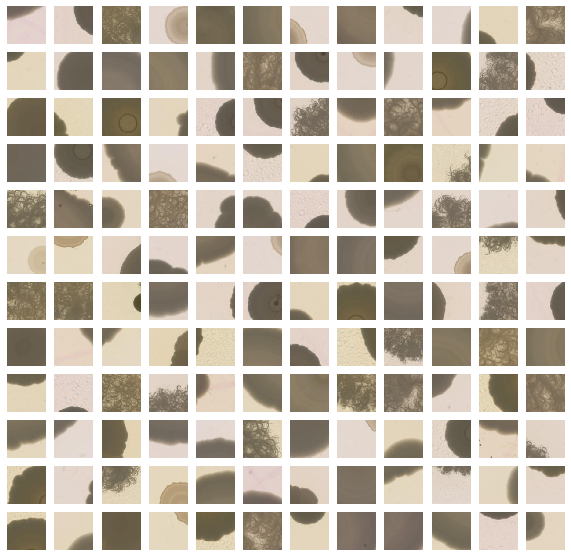

In [10]:
if grouped_classes:
    classes = ['C1','C2-3','C4-7','C5','C6','C8','C9','C10']         # if grouped 'C2-3', 'C4-7'
else:
    classes = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']   # if not grouped
    
pos_patches = []
neg_patches = []

for type_ in ['Serial', 'Control', 'Streak']:
    if len(img_types) > 1:
        if type_ == val_type: continue
    for cls in classes:
        pos_folder = '{}Positive/{}/{}_pos'.format(patch_dir,type_,cls)
        neg_folder = '{}Negative/{}/{}_neg'.format(patch_dir,type_,cls)
        
        pos_class_patches = get_files(pos_folder)
        pos_patches = pos_patches + pos_class_patches
        neg_class_patches = get_files(neg_folder)
        neg_patches = neg_patches + neg_class_patches   

#We randomly visualize some generated patches.
fig, axes1 = plt.subplots(12,12,figsize=(10,10))
for j in range(12):
    for k in range(12):
        i = np.random.choice(range(len(pos_patches)))
        axes1[j][k].set_axis_off()
        patch = Image.open(pos_patches[i])
        axes1[j][k].imshow(np.asarray(patch), cmap="gray")

### If validation, let's randomly visualize some positive _'validation'_ patches:

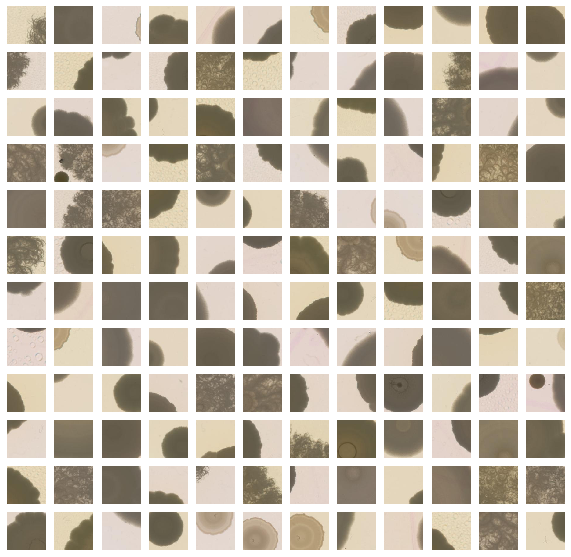

In [29]:
if val_type in ['Serial', 'Control', 'Streak']:
    if grouped_classes:
        classes = ['C1','C2-3','C4-7','C5','C6','C8','C9','C10']         # if grouped 'C2-3', 'C4-7'
    else:
        classes = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']   # if not grouped
    pos_patches = []
    neg_patches = []

    for type_ in ['Serial', 'Control', 'Streak']:
        if type_ != val_type: continue
        for cls in classes:
            pos_folder = '{}Positive/{}/{}_pos'.format(patch_dir,type_,cls)
            neg_folder = '{}Negative/{}/{}_neg'.format(patch_dir,type_,cls)
            pos_class_patches = get_files(pos_folder)
            pos_patches = pos_patches + pos_class_patches
            neg_class_patches = get_files(neg_folder)
            neg_patches = neg_patches + neg_class_patches   

    #We randomly visualize some generated patches.
    fig, axes1 = plt.subplots(12,12,figsize=(10,10))
    for j in range(12):
        for k in range(12):
            i = np.random.choice(range(len(pos_patches)))
            axes1[j][k].set_axis_off()
            patch = Image.open(pos_patches[i])
            axes1[j][k].imshow(np.asarray(patch), cmap="gray")

### Let's randomly visualize some _Negative_ _'training'_ patches:

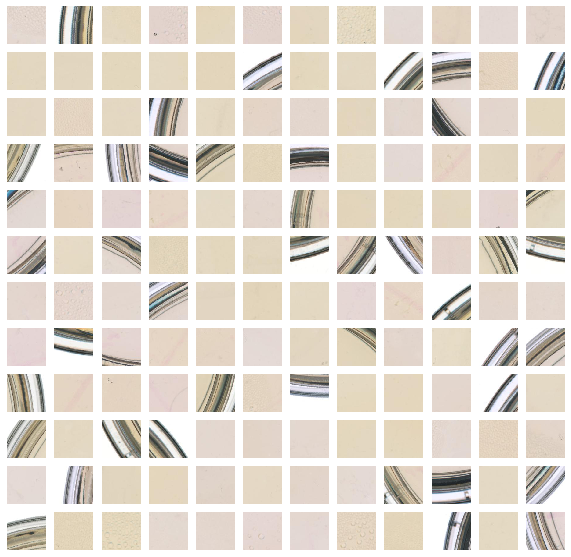

In [12]:
if 'Negative' in patch_types:
    if grouped_classes:
        classes = ['C1','C2-3','C4-7','C5','C6','C8','C9','C10']         # if grouped 'C2-3', 'C4-7'
    else:
        classes = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']   # if not grouped

    pos_patches = []
    neg_patches = []

    for type_ in ['Serial', 'Control', 'Streak']:
        if len(img_types) > 1:
            if type_ == val_type: continue
        for cls in classes:
            pos_folder = '{}Positive/{}/{}_pos'.format(patch_dir,type_,cls)
            neg_folder = '{}Negative/{}/{}_neg'.format(patch_dir,type_,cls)
            pos_class_patches = get_files(pos_folder)
            pos_patches = pos_patches + pos_class_patches
            neg_class_patches = get_files(neg_folder)
            neg_patches = neg_patches + neg_class_patches   

    #We randomly visualize some generated patches.
    fig, axes1 = plt.subplots(12,12,figsize=(10,10))
    for j in range(12):
        for k in range(12):
            i = np.random.choice(range(len(neg_patches)))
            axes1[j][k].set_axis_off()
            patch = Image.open(neg_patches[i])
            axes1[j][k].imshow(np.asarray(patch), cmap="gray")
else:
    print('Negative patche were not generated in the last patch generation run', 
         'include "Negative" in the parameter "patch_types" list and run patch generator again')

### If validation, let's randomly visualize some  _Negative_ _'validation'_ patches:

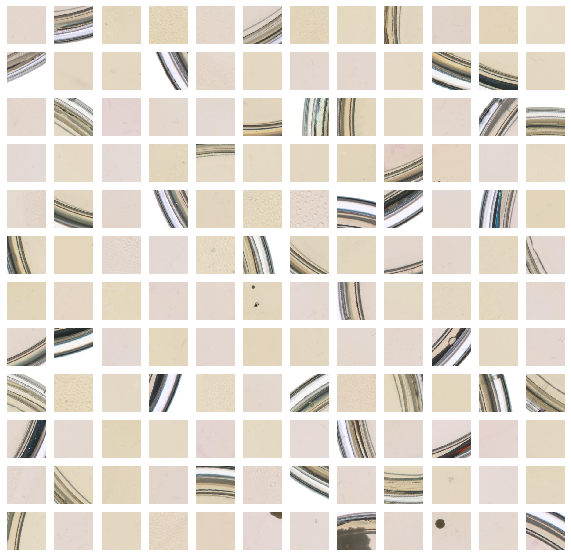

In [30]:
if 'Negative' in patch_types:
    if val_type in ['Serial', 'Control', 'Streak']:
        if grouped_classes:
            classes = ['C1','C2-3','C4-7','C5','C6','C8','C9','C10']         # if grouped 'C2-3', 'C4-7'
        else:
            classes = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']   # if not grouped
        pos_patches = []
        neg_patches = []

        for type_ in ['Serial', 'Control', 'Streak']:
            if type_ != val_type: continue
            for cls in classes:
                pos_folder = '{}Positive/{}/{}_pos'.format(patch_dir,type_,cls)
                neg_folder = '{}Negative/{}/{}_neg'.format(patch_dir,type_,cls)
                pos_class_patches = get_files(pos_folder)
                pos_patches = pos_patches + pos_class_patches
                neg_class_patches = get_files(neg_folder)
                neg_patches = neg_patches + neg_class_patches   

        #We randomly visualize some generated patches.
        fig, axes1 = plt.subplots(12,12,figsize=(10,10))
        for j in range(12):
            for k in range(12):
                i = np.random.choice(range(len(neg_patches)))
                axes1[j][k].set_axis_off()
                patch = Image.open(neg_patches[i])
                axes1[j][k].imshow(np.asarray(patch), cmap="gray")
else:
    print('Negative patche were not generated in the last patch generation run', 
         'include "Negative" in the parameter "patch_types" list and run patch generator again')

### Let's downsample majority classes in training patches:

In [2]:
if grouped_classes:
    classes = ['C1','C2-3','C4-7','C5','C6','C8','C9','C10']         # if grouped 'C2-3', 'C4-7'
else:
    classes = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']   # if not grouped

train_type = 'Serial'

print('Before downsampling "training" patches:')
totals_pos = {}
totals_neg = {}
n_type, type_pos, type_neg = 0, 0, 0
for cls in classes:
    pos_folder = '{}Positive/{}/{}_pos'.format(patch_dir,train_type,cls)
    neg_folder = '{}Negative/{}/{}_neg'.format(patch_dir,train_type,cls)
    n_pos = len(os.listdir(pos_folder))
    n_neg = len(os.listdir(neg_folder))
    total = n_pos + n_neg
    n_type += total
    type_pos += n_pos
    type_neg += n_neg
    print('total_{}: {} = {} positive + {} negative'.format(cls,total,n_pos,n_neg))
    totals_pos['{}'.format(cls)] = n_pos if n_pos else 0
    totals_neg['{}'.format(cls)] = n_neg if n_neg else 0
print('Total {}: {} = {} positive + {} negative\n'.format(train_type,n_type,type_pos,type_neg))

minority_pos = min(totals_pos, key=totals_pos.get)
n_min_pos = min(totals_pos.values())
for key, value in totals_pos.items():
    if key != minority_pos:
        n_to_delete = value - n_min_pos
        root = '{}Positive/{}/{}_pos/'.format(patch_dir,train_type,key)
        patches = os.listdir(root)
        patches_to_delete = np.random.choice(patches, n_to_delete, replace=False)
        for patch in patches_to_delete:
            os.remove(root + patch)

minority_neg = min(totals_neg, key=totals_neg.get)
n_min_neg = min(totals_neg.values())
for key, value in totals_neg.items():
    if key != minority_neg:
        n_to_delete = value - n_min_neg
        root = '{}Negative/{}/{}_neg/'.format(patch_dir,train_type,key)
        patches = os.listdir(root)
        patches_to_delete = np.random.choice(patches, n_to_delete, replace=False)
        for patch in patches_to_delete:
            os.remove(root + patch)

print('After downsampling "training" patches:')
n_type, type_pos, type_neg = 0, 0, 0
for cls in classes:
    pos_folder = '{}Positive/{}/{}_pos'.format(patch_dir,train_type,cls)
    neg_folder = '{}Negative/{}/{}_neg'.format(patch_dir,train_type,cls)
    n_pos = len(os.listdir(pos_folder))
    n_neg = len(os.listdir(neg_folder))
    total = n_pos + n_neg
    n_type += total
    type_pos += n_pos
    type_neg += n_neg
    print('total_{}: {} = {} positive + {} negative'.format(cls,total,n_pos,n_neg))
print('Total {}: {} = {} positive + {} negative'.format(train_type,n_type,type_pos,type_neg))

### For training of Positive vs Negative, let's group all positives, all negatives then balance:

In [19]:
"""let's group all positive and all negative"""

if grouped_classes:
    classes = ['C1','C2-3','C4-7','C5','C6','C8','C9','C10']         # if grouped 'C2-3', 'C4-7'
else:
    classes = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']   # if not grouped0']


for type_ in ['Serial', 'Control', 'Streak']:
    for patch_type in ['Positive', 'Negative']:
        if patch_type == 'Positive':
            sufix = 'pos'
        else:
            sufix = 'neg'
        
        dest = '{}{}/{}/C1_{}'.format(patch_dir,patch_type,type_,sufix) # will move everything to C1
        for cls in classes:
            if cls == 'C1': continue                                         # we will move everything to C1
            root = '{}{}/{}/{}_{}'.format(patch_dir,patch_type,type_,cls,sufix)
            for img in os.listdir(root):
                source = root + '/' + img
                shutil.move(source, dest)
            shutil.rmtree(root)
        os.rename(dest, '{}{}/{}/{}'.format(patch_dir,patch_type,type_,sufix)) # rename C1 to 'pos' or 'neg'
    # let's move 'neg' folder together with 'pos' folder:
    src = '{}{}/{}/{}'.format(patch_dir,'Negative',type_,'neg')
    dst = '{}{}/{}/'.format(patch_dir,'Positive',type_)
    shutil.move(src, dst)
    # let's move 'type_' folder (serial/Control/Streak), one folder up
    src = '{}{}/{}'.format(patch_dir,'Positive',type_)
    dst = '{}'.format(patch_dir)
    shutil.move(src, dst)
shutil.rmtree('{}{}/'.format(patch_dir,'Negative')) # remove 'Negative' folder
shutil.rmtree('{}{}/'.format(patch_dir,'Positive')) # remove 'Positive' folder

"""Let's balance positive vs negative patches"""

print('\nPatches before downsampling:')
for type_ in ['Serial', 'Control', 'Streak']:
    totals = {}
    pos_folder = '{}{}/pos'.format(patch_dir,type_)
    neg_folder = '{}{}/neg'.format(patch_dir,type_)
    n_pos = len(os.listdir(pos_folder))
    n_neg = len(os.listdir(neg_folder))
    total = n_pos + n_neg
    print('total_{}: {} = {} positive + {} negative'.format(type_,total,n_pos,n_neg))
    totals['pos'] = n_pos if n_pos else 0
    totals['neg'] = n_neg if n_neg else 0

    minority = min(totals, key=totals.get)
    n_min = min(totals.values())
    #print('minority:',minority, n_min)
    for key, value in totals.items():
        if key != minority:
            n_to_delete = value - n_min
            root = '{}{}/{}/'.format(patch_dir,type_,key)
            patches = os.listdir(root)
            patches_to_delete = np.random.choice(patches, n_to_delete, replace=False)
            #print('patches_to_delete', len(patches_to_delete))
            for patch in patches_to_delete:
                os.remove(root + patch)

print('\nPatches after downsampling:')
for type_ in ['Serial', 'Control', 'Streak']:
    pos_folder = '{}{}/pos'.format(patch_dir,type_)
    neg_folder = '{}{}/neg'.format(patch_dir,type_)
    n_pos = len(os.listdir(pos_folder))
    n_neg = len(os.listdir(neg_folder))
    total = n_pos + n_neg
    print('total_{}: {} = {} positive + {} negative'.format(type_,total,n_pos,n_neg))


Patches before downsampling:
total_Serial: 63980 = 41150 positive + 22830 negative
total_Control: 22450 = 3710 positive + 18740 negative
total_Streak: 0 = 0 positive + 0 negative

Patches after downsampling:
total_Serial: 45660 = 22830 positive + 22830 negative
total_Control: 7420 = 3710 positive + 3710 negative
total_Streak: 0 = 0 positive + 0 negative


### For final training and validation, let's group negatives only, then balance 9 classes including negative:

In [31]:
"""let's group all negative patches together"""

if grouped_classes:
    classes = ['C1','C2-3','C4-7','C5','C6','C8','C9','C10']         # if grouped 'C2-3', 'C4-7'
else:
    classes = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']   # if not grouped0']

for type_ in ['Serial', 'Control', 'Streak']:
    patch_type = 'Negative'
    sufix = 'neg'
    dest = '{}{}/{}/C1_{}'.format(patch_dir,patch_type,type_,sufix)       # will move everything to C1
    for cls in classes:
        if cls == 'C1': continue                                          # we will move everything to C1
        root = '{}{}/{}/{}_{}'.format(patch_dir,patch_type,type_,cls,sufix)
        for img in os.listdir(root):
            source = root + '/' + img
            shutil.move(source, dest)
        shutil.rmtree(root)
    os.rename(dest, '{}{}/{}/{}'.format(patch_dir,patch_type,type_,sufix)) # rename C1 to 'pos' or 'neg'
    # let's move 'neg' folder together with the other classes in 'Positive' folder:
    src = '{}{}/{}/{}'.format(patch_dir,'Negative',type_,'neg')
    dst = '{}{}/{}/'.format(patch_dir,'Positive',type_)
    shutil.move(src, dst)
    # let's move 'type_' folder (serial/Control/Streak), one folder up
    src = '{}{}/{}'.format(patch_dir,'Positive',type_)
    dst = '{}'.format(patch_dir)
    shutil.move(src, dst)
shutil.rmtree('{}{}/'.format(patch_dir,'Negative')) # remove 'Negative' folder
shutil.rmtree('{}{}/'.format(patch_dir,'Positive')) # remove 'Positive' folder

if grouped_classes:
    classes = ['C1','C2-3','C4-7','C5','C6','C8','C9','C10','neg']         # if grouped 'C2-3', 'C4-7'
else:
    classes = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','neg']   # if not grouped
    
    
    
"""Let's balance all 9 classes (8 positive classes + negative class):"""

if val_type in ['Serial', 'Control', 'Streak']:
    print('Before downsampling validation patches:')
    totals = {}
    n_type = 0
    for cls in classes:
        if cls != 'neg':
            pos_folder = '{}{}/{}_pos'.format(patch_dir,val_type,cls)
        else:
            pos_folder = '{}{}/{}'.format(patch_dir,val_type,cls)
        n = len(os.listdir(pos_folder))
        n_type += n
        print('total_{}: {}'.format(cls,n))
        totals['{}'.format(cls)] = n if n else 0
    print('Total {}: {}\n'.format(val_type,n_type))
    
    minority = min(totals, key=totals.get)
    n_min = min(totals.values())
    #print('minority:',minority, n_min)
    for key, value in totals.items():
        if key != minority:
            n_to_delete = value - n_min
            if key != 'neg':
                root = '{}{}/{}_pos/'.format(patch_dir,val_type,key)
            else:
                root = '{}{}/{}/'.format(patch_dir,val_type,key)   
            patches = os.listdir(root)
            patches_to_delete = np.random.choice(patches, n_to_delete, replace=False)
            #print('patches_to_delete', len(patches_to_delete))
            for patch in patches_to_delete:
                os.remove(root + patch)
                
    print('\nPatches after downsampling:')
    n_type = 0
    for cls in classes:
        if cls != 'neg':
            pos_folder = '{}{}/{}_pos'.format(patch_dir,val_type,cls)
        else:
            pos_folder = '{}{}/{}'.format(patch_dir,val_type,cls)
        n = len(os.listdir(pos_folder))
        n_type += n
        print('total_{}: {}'.format(cls,n))
    print('Total {}: {}\n'.format(val_type,n_type))

Before downsampling validation patches:
total_C1: 6610
total_C2-3: 6610
total_C4-7: 6610
total_C5: 6610
total_C6: 6610
total_C8: 6610
total_C9: 6610
total_C10: 6610
total_neg: 267096
Total Control: 319976


Patches after downsampling:
total_C1: 6610
total_C2-3: 6610
total_C4-7: 6610
total_C5: 6610
total_C6: 6610
total_C8: 6610
total_C9: 6610
total_C10: 6610
total_neg: 6610
Total Control: 59490

